# Search engine and recommender

Couldn't have done it without [this resource](https://www.youtube.com/watch?v=5n652PtXBdo) 

In [6]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

## Importing and cleaning corpus

In [10]:
PODCASTS = 'uncleaned_podcasts.csv'
df_podcasts = pd.read_csv(PODCASTS)
df_podcasts.head()

,Title,Body
0,New Beginnings,Joe Franklin? I'm ready. It's Ira Glass here. ...
1,Small Scale Sin,"OK, three boys, aged 13, 15, and 16. All three..."
2,Poultry Slam 1995,"In Danielle's house, ever since she was a girl..."
3,Vacations,The thing about Hawaii is that before you go a...
4,Anger and Forgiveness,Hi. It's Ira Glass recording this in 2006. An...


In [27]:
df_podcasts.dropna(inplace=True)

In [28]:
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'

def preprocess(text):
    tokenized = [word for sent in [re.sub(SPECIAL_CHARS, '', element).split(' ') for
                                  element in nltk.sent_tokenize(text)] for word in sent]
    
    lowered = [word.lower() for word in tokenized]
    return lowered

In [29]:
podcast_texts = [preprocess(text) for text in df_podcasts['Body'].tolist()]

podcast_texts[0][:10]

['joe',
 'franklin',
 'im',
 'ready',
 'its',
 'ira',
 'glass',
 'here',
 'oh',
 'youre']

In [33]:
cleaned_dct = dict(zip(df_podcasts['Title'], podcast_texts))

## Using Gensim to create Word Embedding Space

In [94]:
import pickle

In [34]:
# import gensim.downloader as api

# path = api.load("word2vec-google-news-300", return_path=True)
# print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/Users/Manny/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [36]:
path = '/Users/Manny/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

w2v = KeyedVectors.load_word2vec_format(path, binary=True)


'''Pickles the the podcast vector'''
with open('w2v.pkl', 'wb') as handle:
    pickle.dump(w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
#note: .items() returns dictionary as list of tuples where first element is key and second is value
#returns same dictionary with a vector in place for each word or article

def get_vectors(first_map, second_map):
    first_vec = dict() 
    for key, value_list in first_map.items():
        temp = list()
        for element in value_list:
            try:
                temp.append(second_map[element])
            except KeyError:
                pass
        
        first_vec[key] = np.mean(temp, axis=0)
        
    return first_vec

In [53]:
podcast_vec = get_vectors(cleaned_dct, w2v)


'''Pickles the the podcast vector'''
with open('podcast_vec.pkl', 'wb') as handle:
    pickle.dump(podcast_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
def user_search(query, liked_podcasts=None):
    user_vec = get_vectors({'search': query.split(' ')}, w2v)
    
    if liked_podcasts:
        likes_dct = get_vectors({'likes': liked_podcasts}, podcast_vec)
        user_vec['likes'] = likes_dct['likes']
    
    return user_vec

## Cosine Similarity and a Recommender


In [76]:
def get_most_similar(podcast_vec, user_vec, likes=[]):
    sim = list()
        
    for key, vec in podcast_vec.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), user_vec.reshape(1, -1))
        if key not in likes:
            sim.append((key, thisSim[0][0]))
    
    return sorted(sim, key=lambda x: x[1], reverse=True)

In [114]:
users_likes = ['What Is This Thing?', 'I Enjoy Being A Girl, Sort Of']
user_vec = user_search("monogamy", liked_podcasts=users_likes)

print(get_most_similar(podcast_vec, user_vec['search'])[:5])
print('\nRecommended for you...')
print(get_most_similar(podcast_vec, user_vec['likes'], likes=users_likes)[:5])

[('Monogamy', 0.26783395), ('The Sanctity of Marriage', 0.24621944), ('Double Lives', 0.24034779), ('81 Words', 0.23817109), ('Godless America', 0.2378855)]

Recommended for you...
[('Frenemies', 0.99678993), ('Living the Dream', 0.9963706), ('Love', 0.9958979), ('The Missing Parents Bureau', 0.9958873), ('Give the People What They Want', 0.99571747)]


## Visualizations

In [88]:
def tsne_plot(mapping):
    values = np.asarray(list(mapping.values()))
    labels = list(mapping.keys())
    
    tsne = TSNE(n_components=2, random_state=1)
    new_values = tsne.fit_transform(values)
    
    x, y = [], []
    
    for item in new_values:
        x.append(item[0])
        y.append(item[1])
    
    plt.figure(figsize=(20, 20))
    for ix, _ in enumerate(x):
        if labels[ix]=='search':
            #color = 'green'
            #alpha = 0.7
            pass
        elif labels[ix]=='likes':
            color = 'blue'
            alpha = 0.7
        else: 
            color = 'red'
            alpha = 0.3
        plt.scatter(x[ix], y[ix], color=color, alpha=alpha)
        
    red_patch = mpatches.Patch(color='red', label='all_podcasts')
    blue_patch = mpatches.Patch(color='blue', label='user_profile')
    #green_patch = mpatches.Patch(color='green', label='user_search')
    plt.legend(handles=[red_patch, blue_patch], fontsize=16)
    plt.show

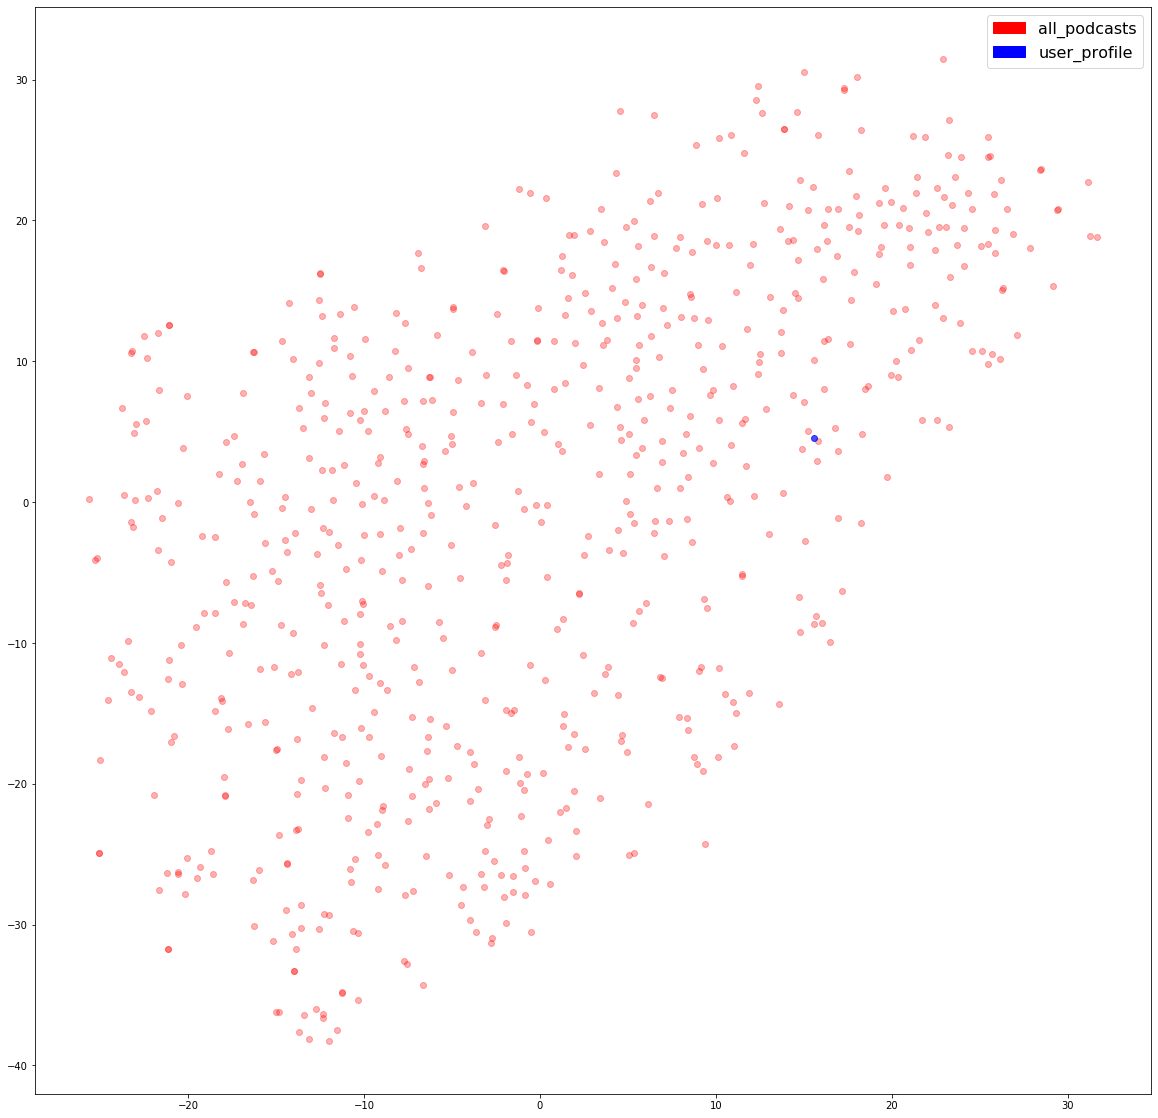

In [89]:
tsne_plot({**podcast_vec, **user_vec})

## Retrieving the IDs for each Porcast Title


In [108]:
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import clear_output

def get_title_ids(files=[1, 715]):

    titles = {'N/A': []}
    malfunctions = []

    # There are 715 podcasts 
    for pcast_n in range(files[0], files[1]+1):
        # Scrape the html from the podcast website
        link = f'https://www.thisamericanlife.org/{pcast_n}/transcript'
        response = requests.get(link)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html5lib')
            time.sleep(0.1)
        
            # filter the podcast title and dialogue as body
            try:
                title = soup.find('h1').text.split(': ')[1]
            except AttributeError:
                tilte = 'N/A'
                
            titles[title] = pcast_n
            
        else:
            malfunctions.append(pcast_n)
        
        clear_output(wait=True)
        print(f'Scraping {pcast_n} files...')
        
    if malfunctions:
        print(f'The following {len(malfunctions)} files failed to upload...\n', malfunctions )
    else:
        print(f'All {files[1]} files uploaded successfully.')
        
    return titles

In [109]:
title_ids = get_title_ids()

Scraping 715 files...
The following 3 files failed to upload...
 [460, 497, 686]


In [118]:
'''Pickles the the ids'''
with open('title_ids.pkl', 'wb') as handle:
    pickle.dump(title_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)